In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle

from scripts.smdp_agent import SMDPQLearningAgent
from scripts.taxi_utils import TaxiUtils as tu
from scripts.taxi_visualizer import TaxiVisualizer as tv
from scripts.options import Option
from scripts.policies import MoveTaxiPolicy, EpsilonGreedyPolicy, OptimalPolicy, PickUpPassenger, DropOffPassenger
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results, compute_decay

## Hyperparameters

In [2]:
def episode_trigger(x):
    if x % 1000 == 0:
        return True
    return False

def process_hyperparameters(hyperparameters):
    hyperparameters.update({
        "eps_decay": compute_decay(
            hyperparameters["eps_start"],
            hyperparameters["eps_end"],
            hyperparameters["frac_episodes_to_decay"],
            hyperparameters["num_episodes"],
            hyperparameters["decay_type"]
        )
    })

    hyperparameters.pop("frac_episodes_to_decay", None)
    return hyperparameters
    

In [3]:
# Top 3 hyperparameter configurations
smdp_hyperparameter_list = [

    process_hyperparameters(_) for _ in  [
    # Best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": 8,
        "LR": 1e-3,
        "eps_start": 1,
        "eps_end": 0.001,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.5
    }

]]

## Running Experiments

In [4]:
def get_termination(source):
    # ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
    termination = [0 for i in range(500)]
    
    base = 100*source[0] + 20*source[1]
    idx = tu.LOC_TO_COLOR[source]

    for i in range(4):
        for j in range(5):
            if j!=idx:
                termination[base + j*4 + i] = 1

    return termination
    
initiation_set = [True for i in range(500)]
termination = [1 for i in range(500)]

# options = [
#     Option(0, initiation_set, OptimalPolicy(), termination, seed=0, label="Optimal Policy")
# ]

options = [
    Option(0, initiation_set, PickUpPassenger(), termination, seed=0, label="Pick up Passenger"),
    Option(1, initiation_set, DropOffPassenger(), termination, seed=0, label="Drop off Passenger")
]

In [5]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="backups/taxi-smdp-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)

smdp_agent = SMDPQLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    options=options,
    seed=0
)

trainer = Trainer()
smdp_results = test_agent(env, smdp_agent, trainer, smdp_hyperparameter_list, num_experiments=1)
env.close()

# with open("backups/acrobot-plots/acrobot_ddqn_type1_results.pickle", 'wb') as handle:
#     pickle.dump(ddqn_type1_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment3/DA6400_RL_PA3/backups/taxi-smdp-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


LR 0.001
eps_start 1
eps_end 0.001
decay_type exponential
eps_decay 0.9986194028465246


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 685.64it/s, Mean Score=-0.31]


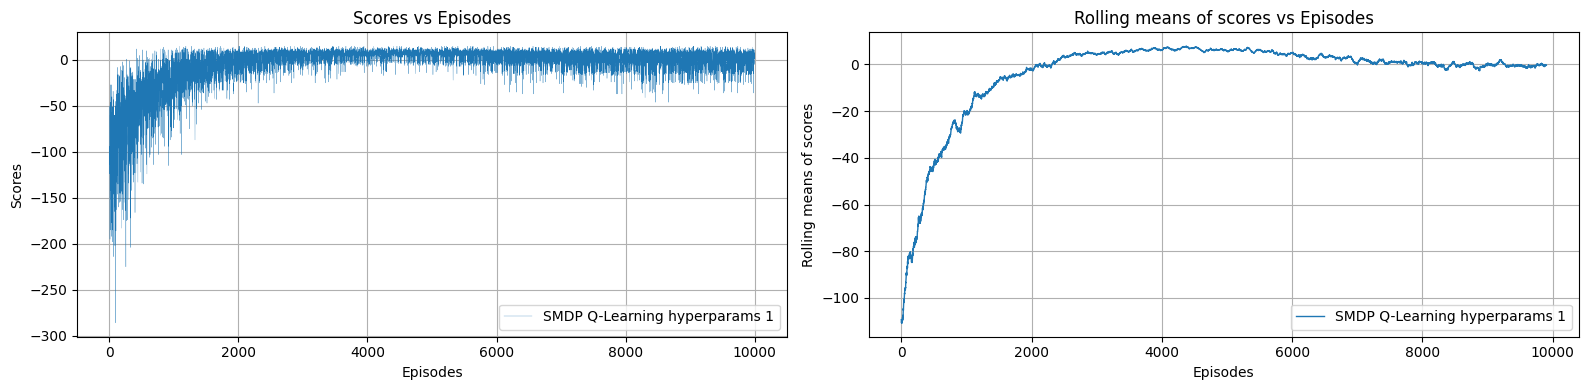

In [6]:
plot_test_results(smdp_results, [0])

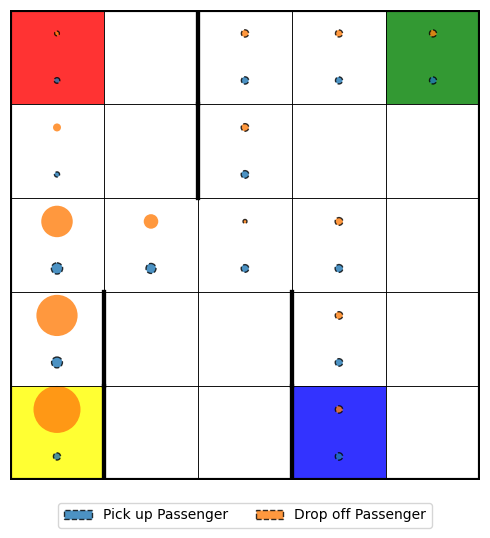

In [8]:
def vis(state, Qtable, option_labels=None):

    taxi_row, taxi_col, passenger_location, destination = tu.decode_env_state(state)
    
    fig, ax = plt.subplots(figsize=(5, 5))

    tv.visualize_adjacency()
    tv.visualize_locations()

    option_values = Qtable[:,:,passenger_location, destination,:]
    options = np.max(option_values, axis=-1)

    # tv.visualize_options(options, option_labels)
    
    tv.visualize_options_bubble_plot(option_values, option_labels, norm_axis=None)
    
    # tv.visualize_heatmap(qvals)
    # tv.visualize_taxi_passenger_destination(state)


    fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    

option_labels = {}
for option in options:
    option_labels[option.index] = option.label
    
Qtable = np.reshape(smdp_agent.Qtable, (5,5,5,4,-1))
vis(tu.encode_env_state(3, 3, tu.IN_TAXI, tu.YELLOW), Qtable, option_labels)